In [1]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import pickle

# load calibration matrix
with open('calibration.pickle', 'rb') as f:
    mtx,dist = pickle.load(f)


In [3]:
# load perspective transform
with open('perspective.pickle', 'rb') as f:
    M,Minv = pickle.load(f)

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask. Copied from P1.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [223]:
# pipeline components
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def color_threshold(img):
    # get RGB and HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    #R threshold
    r_thresh = (200, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

    #S threshold
    s_thresh = (90, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1

    # stack R and S
    combined_binary = np.zeros_like(S)
    combined_binary[((s_binary == 1) & (r_binary == 1))] = 1

    return combined_binary

def region_mask(img):
    buffer_bucket = 15

    xsize,ysize = img.shape[1],img.shape[0]

    x_buffer    = xsize / buffer_bucket

    lower_left  = (x_buffer,       ysize)
    lower_right = (xsize-x_buffer, ysize)
    top_left    = (xsize/2-10,     ysize/2+60) # normally the horizon is towards the bottom half
    top_right   = (xsize/2+10,     ysize/2+60)

    vertices = np.array([[
                lower_left,
                top_left,
                top_right,
                lower_right
            ]], dtype=np.int32)

    region = region_of_interest(img, vertices)

    return region

def perspective_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def get_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def histogram_search(img):
    # get histogram
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    # fit polynomial
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    window_size = 100
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_size
        win_y_high = img.shape[0] - window*window_size
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty
    

def histogram_search_next(img, left_fit, right_fit):
    print("searching from last histogram")
    # carry over from previous fit
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty



def draw_back(undistorted, warped, left_fit, right_fit):
    # Generate x and y values for plotting
    fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result

In [245]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # first pass?
        self.first_pass = True
        #radius of curvature of the line in some units
        self.curvature_left = None 
        self.curvature_right = None
        #current fit
        self.best_fit_lefts = []
        self.best_fit_rights = []
        
        # below are not used for now

        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def get_histogram_search(self, warped):
        if self.first_pass:
            return histogram_search(warped)
        else:
            return histogram_search_next(warped, self.current_fit_x, self.current_fit_y)
    
    def get_fit(self, leftx, lefty, rightx, righty):
        if self.first_pass:
            self.first_pass = False
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # save curvature
            self.curvature_left, self.curvature_right = get_curvature(leftx,lefty,rightx,righty)
            # save fit
            self.best_fit_lefts.append(left_fit)
            self.best_fit_rights.append(right_fit)
            return left_fit, right_fit
        else:
            margin = 200
            offset = 5
            try:
                curvature = get_curvature(leftx,lefty,rightx,righty)
                left_fit = np.polyfit(lefty, leftx, 2)
                right_fit = np.polyfit(righty, rightx, 2)
                
                if left_fit[0] * right_fit[0] >= 0: # same direction
                    if abs(curvature[0] - self.curvature_left) < margin:
                        print("updating left fit, last curvature:", self.curvature_left, " new curvature", curvature[0])
                        self.curvature_left = curvature[0]
                        self.best_fit_lefts.append(np.polyfit(lefty, leftx, 2))
                        print("good lefts:", len(self.best_fit_lefts))
                    if abs(curvature[1] - self.curvature_right) < margin:
                        print("updating right fit, last curvature:", self.curvature_right, " new curvature", curvature[1])
                        self.curvature_right = curvature[1]
                        self.best_fit_rights.append(np.polyfit(righty,rightx,2))
                        print("good rights:", len(self.best_fit_rights))
                else:
                    print("diff direction!")
            except:
                pass
                        
            return np.mean(np.array(self.best_fit_lefts[-1*offset:]), axis=0).tolist(),np.mean(np.array(self.best_fit_rights[-1*offset:]), axis=0).tolist()          
            

In [246]:
def pipeline(img, line):
    
    #undistort
    undistorted = undistort(img)
    
    #color threshold
    combined_binary = color_threshold(undistorted)
    
    # region of interest
    region = region_mask(combined_binary)
    
    # perspective transform
    warped = perspective_transform(region)
    
    # get histogram search
    leftx,lefty,rightx,righty = line.get_histogram_search(warped)
    print("leftx:", len(leftx), "rightx:", len(rightx))
    
    line.current_fit_x, line.current_fit_y = line.get_fit(leftx,lefty,rightx,righty)
    
    # draw back
    result = draw_back(undistorted, warped, line.current_fit_x, line.current_fit_y)
    
    return result

applying lane to image... test_images/straight_lines1.jpg
leftx: 9215 rightx: 943


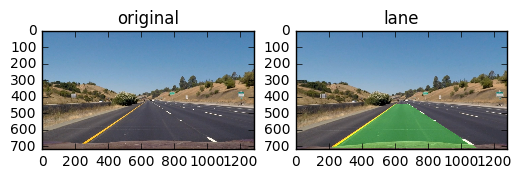

applying lane to image... test_images/straight_lines2.jpg
leftx: 1884 rightx: 5980


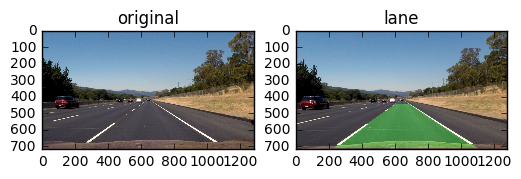

applying lane to image... test_images/test1.jpg
leftx: 43203 rightx: 1703


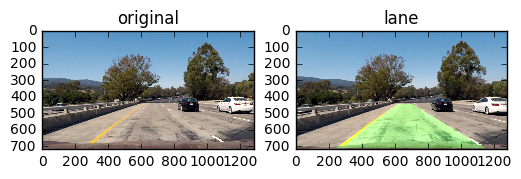

applying lane to image... test_images/test2.jpg
leftx: 10536 rightx: 876


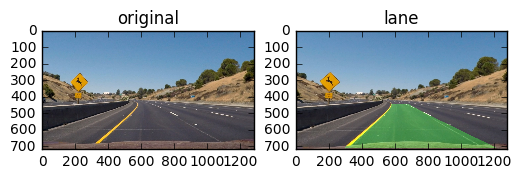

applying lane to image... test_images/test3.jpg
leftx: 8442 rightx: 1613


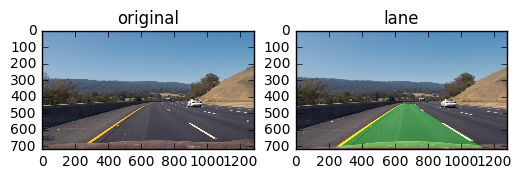

applying lane to image... test_images/test4.jpg
leftx: 44517 rightx: 1163


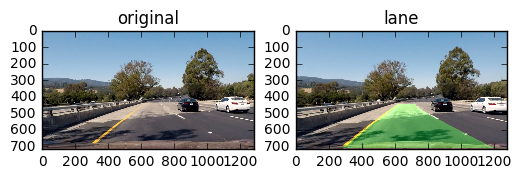

applying lane to image... test_images/test5.jpg
leftx: 5189 rightx: 1393


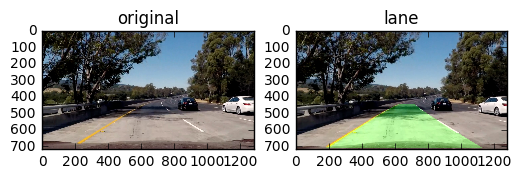

applying lane to image... test_images/test6.jpg
leftx: 6317 rightx: 570


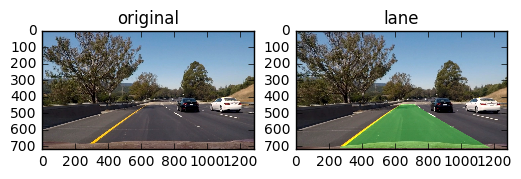

In [226]:
import glob
images = glob.glob('test_images/*.jpg')

line = Line()

for idx, fname in enumerate(images):
    line = Line()
    img = mpimg.imread(fname)
    print("applying lane to image...", fname)
    plt.figure(idx+1)
    plt.subplot(1,2,1)
    plt.title("original")
    plt.imshow(img)
    
    lane = pipeline(img, line)
    plt.subplot(1,2,2)
    plt.title("lane")
    plt.imshow(lane, cmap='gray')
    plt.show()

leftx: 9095 rightx: 1027


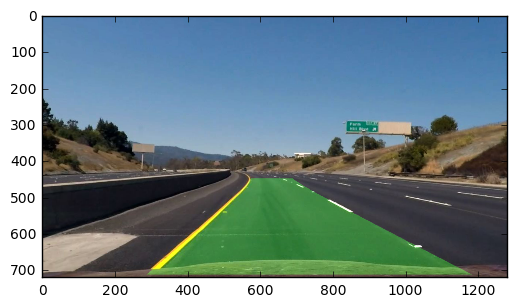

In [241]:
line = Line()

idx = 0
fname = 'project_video_4s/project_video_4s 024.jpg'
img = mpimg.imread(fname)
lane = pipeline(img, line)
plt.imshow(lane)


In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [244]:
%matplotlib inline
line = Line()
def process_image(img):
    global line
    return pipeline(img, line)

In [234]:
output = 'project_video_output_4s.mp4'
clip1 = VideoFileClip("project_video_4s.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

leftx: 11001 rightx: 1655
[MoviePy] >>>> Building video project_video_output_4s.mp4
[MoviePy] Writing video project_video_output_4s.mp4


  0%|          | 0/102 [00:00<?, ?it/s]

searching from last histogram
leftx: 11001 rightx: 1655
updating left fit, last curvature: 521.718068322  new curvature 521.718068322
good lefts: 2
updating right fit, last curvature: 846.463412252  new curvature 846.463412252
good rights: 2


  2%|▏         | 2/102 [00:00<00:20,  4.77it/s]

searching from last histogram
leftx: 11091 rightx: 1788
updating left fit, last curvature: 521.718068322  new curvature 511.094366229
good lefts: 3
searching from last histogram
leftx: 10972 rightx: 1795


  3%|▎         | 3/102 [00:00<00:20,  4.82it/s]

updating left fit, last curvature: 511.094366229  new curvature 503.190692728
good lefts: 4
searching from last histogram
leftx: 10720 rightx: 1777
updating left fit, last curvature: 503.190692728  new curvature 504.703132578
good lefts: 5


  5%|▍         | 5/102 [00:01<00:19,  4.98it/s]

searching from last histogram
leftx: 10172 rightx: 1487
updating left fit, last curvature: 504.703132578  new curvature 496.655726494
good lefts: 6
searching from last histogram
leftx: 10110 rightx: 1137
updating left fit, last curvature: 496.655726494  new curvature 504.986111678
good lefts: 7


  7%|▋         | 7/102 [00:01<00:18,  5.05it/s]

searching from last histogram
leftx: 10269 rightx: 929
updating left fit, last curvature: 504.986111678  new curvature 535.150104386
good lefts: 8
searching from last histogram
leftx: 9912 rightx: 737
updating left fit, last curvature: 535.150104386  new curvature 530.330092035
good lefts: 9


  9%|▉         | 9/102 [00:01<00:18,  4.97it/s]

searching from last histogram
leftx: 10129 rightx: 883
updating left fit, last curvature: 530.330092035  new curvature 558.342013401
good lefts: 10


 10%|▉         | 10/102 [00:02<00:18,  4.91it/s]

searching from last histogram
leftx: 10416 rightx: 988
updating left fit, last curvature: 558.342013401  new curvature 584.392104533
good lefts: 11
updating right fit, last curvature: 846.463412252  new curvature 661.530666268
good rights: 3


 11%|█         | 11/102 [00:02<00:18,  4.89it/s]

searching from last histogram
leftx: 10170 rightx: 1069
updating left fit, last curvature: 584.392104533  new curvature 582.913403014
good lefts: 12
updating right fit, last curvature: 661.530666268  new curvature 653.097344741
good rights: 4


 12%|█▏        | 12/102 [00:02<00:18,  4.89it/s]

searching from last histogram
leftx: 10379 rightx: 1219
updating left fit, last curvature: 582.913403014  new curvature 640.857747513
good lefts: 13
updating right fit, last curvature: 653.097344741  new curvature 560.920098543
good rights: 5
searching from last histogram
leftx: 10210 rightx: 1274
updating left fit, last curvature: 640.857747513  new curvature 660.091157265
good lefts: 14
updating right fit, last curvature: 560.920098543  new curvature 583.192736843
good rights: 6


 14%|█▎        | 14/102 [00:02<00:17,  4.99it/s]

searching from last histogram
leftx: 10286 rightx: 1438
updating left fit, last curvature: 660.091157265  new curvature 676.406499532
good lefts: 15
updating right fit, last curvature: 583.192736843  new curvature 587.835442978
good rights: 7
searching from last histogram
leftx: 10038 rightx: 1571
updating left fit, last curvature: 676.406499532  new curvature 651.225409485


 15%|█▍        | 15/102 [00:03<00:17,  5.00it/s]

good lefts: 16
updating right fit, last curvature: 587.835442978  new curvature 603.788171829
good rights: 8
searching from last histogram
leftx: 10042 rightx: 1563
updating left fit, last curvature: 651.225409485  new curvature 638.601268382
good lefts: 17
updating right fit, last curvature: 603.788171829  new curvature 634.51642788
good rights: 9


 17%|█▋        | 17/102 [00:03<00:16,  5.08it/s]

searching from last histogram
leftx: 9806 rightx: 1618
updating left fit, last curvature: 638.601268382  new curvature 626.191429417
good lefts: 18
updating right fit, last curvature: 634.51642788  new curvature 590.090034625
good rights: 10
searching from last histogram
leftx: 9705 rightx: 1449
updating left fit, last curvature: 626.191429417  new curvature 634.378223551
good lefts: 19


 19%|█▊        | 19/102 [00:03<00:16,  5.15it/s]

searching from last histogram
leftx: 9868 rightx: 1112
updating left fit, last curvature: 634.378223551  new curvature 678.248712062
good lefts: 20
searching from last histogram
leftx: 9628 rightx: 862


 20%|█▉        | 20/102 [00:03<00:16,  5.12it/s]

updating left fit, last curvature: 678.248712062  new curvature 717.023755862
good lefts: 21
searching from last histogram
leftx: 9828 rightx: 743
updating left fit, last curvature: 717.023755862  new curvature 759.60417773
good lefts: 22


 22%|██▏       | 22/102 [00:04<00:15,  5.11it/s]

searching from last histogram
leftx: 9986 rightx: 930
updating left fit, last curvature: 759.60417773  new curvature 814.904015814
good lefts: 23
updating right fit, last curvature: 590.090034625  new curvature 577.749813561
good rights: 11
searching from last histogram
leftx: 10086 rightx: 974
updating left fit, last curvature: 814.904015814  new curvature 862.119625414
good lefts: 24
updating right fit, last curvature: 577.749813561  new curvature 562.768488376
good rights: 12


 24%|██▎       | 24/102 [00:04<00:15,  5.06it/s]

searching from last histogram
leftx: 9825 rightx: 1059
updating left fit, last curvature: 862.119625414  new curvature 789.183820196
good lefts: 25
updating right fit, last curvature: 562.768488376  new curvature 696.169570275
good rights: 13
searching from last histogram
leftx: 9897 rightx: 1122
updating left fit, last curvature: 789.183820196  new curvature 709.568513395
good lefts: 26
updating right fit, last curvature: 696.169570275  new curvature 810.682890699
good rights: 14


 25%|██▌       | 26/102 [00:05<00:14,  5.11it/s]

searching from last histogram
leftx: 9995 rightx: 1099
updating left fit, last curvature: 709.568513395  new curvature 726.409390641
good lefts: 27
searching from last histogram
leftx: 9898 rightx: 1315
updating left fit, last curvature: 726.409390641  new curvature 701.313818728
good lefts: 28


 27%|██▋       | 28/102 [00:05<00:14,  5.14it/s]

searching from last histogram
leftx: 10194 rightx: 1355
updating left fit, last curvature: 701.313818728  new curvature 734.856481296
good lefts: 29
searching from last histogram
leftx: 10144 rightx: 1719
updating left fit, last curvature: 734.856481296  new curvature 660.835950938
good lefts: 30
updating right fit, last curvature: 810.682890699  new curvature 630.50513528
good rights: 15


 29%|██▉       | 30/102 [00:05<00:14,  5.11it/s]

searching from last histogram
leftx: 9966 rightx: 1475
updating left fit, last curvature: 660.835950938  new curvature 567.825645016
good lefts: 31
updating right fit, last curvature: 630.50513528  new curvature 603.600828647
good rights: 16
searching from last histogram
leftx: 9957 rightx: 1472
updating left fit, last curvature: 567.825645016  new curvature 518.42745407
good lefts: 32
updating right fit, last curvature: 603.600828647  new curvature 596.368185273
good rights: 17


 31%|███▏      | 32/102 [00:06<00:13,  5.07it/s]

searching from last histogram
leftx: 9772 rightx: 1054
updating left fit, last curvature: 518.42745407  new curvature 472.714622887
good lefts: 33
updating right fit, last curvature: 596.368185273  new curvature 541.565750363
good rights: 18
searching from last histogram
leftx: 9524 rightx: 690
updating left fit, last curvature: 472.714622887  new curvature 472.278451611
good lefts: 34
updating right fit, last curvature: 541.565750363  new curvature 577.833607052
good rights: 19


 33%|███▎      | 34/102 [00:06<00:13,  5.07it/s]

searching from last histogram
leftx: 9545 rightx: 688
updating left fit, last curvature: 472.278451611  new curvature 450.794048688
good lefts: 35
searching from last histogram
leftx: 9411 rightx: 731
updating left fit, last curvature: 450.794048688  new curvature 440.25477221
good lefts: 36


 35%|███▌      | 36/102 [00:07<00:13,  5.04it/s]

searching from last histogram
leftx: 9247 rightx: 840
updating left fit, last curvature: 440.25477221  new curvature 425.647881365
good lefts: 37
searching from last histogram


 36%|███▋      | 37/102 [00:07<00:12,  5.01it/s]

leftx: 8976 rightx: 995
updating left fit, last curvature: 425.647881365  new curvature 417.865658855
good lefts: 38
searching from last histogram
leftx: 9197 rightx: 1018
updating left fit, last curvature: 417.865658855  new curvature 399.514779809
good lefts: 39
updating right fit, last curvature: 577.833607052  new curvature 638.066100575
good rights: 20


 38%|███▊      | 39/102 [00:07<00:12,  5.05it/s]

searching from last histogram
leftx: 9224 rightx: 1045
updating left fit, last curvature: 399.514779809  new curvature 392.012427722
good lefts: 40
updating right fit, last curvature: 638.066100575  new curvature 584.789306759
good rights: 21
searching from last histogram
leftx: 9079 rightx: 1198
updating left fit, last curvature: 392.012427722  new curvature 394.584049036
good lefts: 41
updating right fit, last curvature: 584.789306759  new curvature 557.364493978
good rights: 22


 40%|████      | 41/102 [00:08<00:11,  5.13it/s]

searching from last histogram
leftx: 8820 rightx: 1363
updating left fit, last curvature: 394.584049036  new curvature 393.018783048
good lefts: 42
updating right fit, last curvature: 557.364493978  new curvature 625.909244946
good rights: 23
searching from last histogram
leftx: 8852 rightx: 1588
updating left fit, last curvature: 393.018783048  new curvature 402.69081383
good lefts: 43
updating right fit, last curvature: 625.909244946  new curvature 628.550494603
good rights: 24


 42%|████▏     | 43/102 [00:08<00:11,  5.15it/s]

searching from last histogram
leftx: 8901 rightx: 1357
updating left fit, last curvature: 402.69081383  new curvature 399.062192057
good lefts: 44
updating right fit, last curvature: 628.550494603  new curvature 700.901371251
good rights: 25
searching from last histogram
leftx: 9158 rightx: 1122
updating left fit, last curvature: 399.062192057  new curvature 414.667649123
good lefts: 45
updating right fit, last curvature: 700.901371251  new curvature 568.486295498
good rights: 26


 44%|████▍     | 45/102 [00:08<00:11,  5.15it/s]

searching from last histogram
leftx: 9236 rightx: 898
updating left fit, last curvature: 414.667649123  new curvature 423.563713715
good lefts: 46
updating right fit, last curvature: 568.486295498  new curvature 502.965694789
good rights: 27
searching from last histogram


 45%|████▌     | 46/102 [00:09<00:10,  5.10it/s]

leftx: 9304 rightx: 750
updating left fit, last curvature: 423.563713715  new curvature 437.695245655
good lefts: 47
searching from last histogram
leftx: 9423 rightx: 822
updating left fit, last curvature: 437.695245655  new curvature 461.071527892
good lefts: 48


 47%|████▋     | 48/102 [00:09<00:10,  5.05it/s]

searching from last histogram
leftx: 9267 rightx: 917
updating left fit, last curvature: 461.071527892  new curvature 473.133076518
good lefts: 49
searching from last histogram
leftx: 9385 rightx: 1021
updating left fit, last curvature: 473.133076518  new curvature 506.990525413
good lefts: 50


 49%|████▉     | 50/102 [00:09<00:10,  5.13it/s]

searching from last histogram
leftx: 9446 rightx: 1065
updating left fit, last curvature: 506.990525413  new curvature 528.1017081
good lefts: 51
searching from last histogram
leftx: 9242 rightx: 1093
updating left fit, last curvature: 528.1017081  new curvature 560.113061423
good lefts: 52
updating right fit, last curvature: 502.965694789  new curvature 574.796503915
good rights: 28


 51%|█████     | 52/102 [00:10<00:09,  5.14it/s]

searching from last histogram
leftx: 9224 rightx: 1180
updating left fit, last curvature: 560.113061423  new curvature 581.294163264
good lefts: 53
updating right fit, last curvature: 574.796503915  new curvature 532.501501652
good rights: 29
searching from last histogram
leftx: 9155 rightx: 1303
updating left fit, last curvature: 581.294163264  new curvature 618.476130967
good lefts: 54
updating right fit, last curvature: 532.501501652  new curvature 566.02625115
good rights: 30


 53%|█████▎    | 54/102 [00:10<00:09,  5.20it/s]

searching from last histogram
leftx: 9063 rightx: 1551
updating left fit, last curvature: 618.476130967  new curvature 641.081073083
good lefts: 55
updating right fit, last curvature: 566.02625115  new curvature 597.124186183
good rights: 31
searching from last histogram


 54%|█████▍    | 55/102 [00:10<00:09,  5.12it/s]

leftx: 9075 rightx: 1596
updating left fit, last curvature: 641.081073083  new curvature 672.939547457
good lefts: 56
updating right fit, last curvature: 597.124186183  new curvature 567.817650086
good rights: 32
searching from last histogram
leftx: 9132 rightx: 1308
updating left fit, last curvature: 672.939547457  new curvature 713.551284142
good lefts: 57
updating right fit, last curvature: 567.817650086  new curvature 525.052111268
good rights: 33


 56%|█████▌    | 57/102 [00:11<00:08,  5.14it/s]

searching from last histogram
leftx: 9140 rightx: 1006
updating left fit, last curvature: 713.551284142  new curvature 738.789110695
good lefts: 58
updating right fit, last curvature: 525.052111268  new curvature 516.964264905
good rights: 34
searching from last histogram
leftx: 9277 rightx: 770
updating left fit, last curvature: 738.789110695  new curvature 756.778224656
good lefts: 59
updating right fit, last curvature: 516.964264905  new curvature 430.744966299
good rights: 35


 58%|█████▊    | 59/102 [00:11<00:08,  5.18it/s]

searching from last histogram
leftx: 9122 rightx: 765
updating left fit, last curvature: 756.778224656  new curvature 695.645932631
good lefts: 60
searching from last histogram
leftx: 9054 rightx: 809
updating left fit, last curvature: 695.645932631  new curvature 665.408973505
good lefts: 61


 60%|█████▉    | 61/102 [00:11<00:07,  5.20it/s]

searching from last histogram
leftx: 9206 rightx: 1107
updating left fit, last curvature: 665.408973505  new curvature 660.286367448
good lefts: 62
searching from last histogram
leftx: 9045 rightx: 1177
updating left fit, last curvature: 660.286367448  new curvature 639.821207646
good lefts: 63


 62%|██████▏   | 63/102 [00:12<00:07,  5.19it/s]

searching from last histogram
leftx: 9247 rightx: 1199
updating left fit, last curvature: 639.821207646  new curvature 640.138074857
good lefts: 64
updating right fit, last curvature: 430.744966299  new curvature 580.48272309
good rights: 36
searching from last histogram
leftx: 9357 rightx: 1330
updating left fit, last curvature: 640.138074857  new curvature 621.480671028
good lefts: 65
updating right fit, last curvature: 580.48272309  new curvature 587.335081322
good rights: 37


 64%|██████▎   | 65/102 [00:12<00:07,  5.21it/s]

searching from last histogram
leftx: 9462 rightx: 1488
updating left fit, last curvature: 621.480671028  new curvature 628.102781336
good lefts: 66
updating right fit, last curvature: 587.335081322  new curvature 610.065137898
good rights: 38
searching from last histogram
leftx: 9321 rightx: 1596
updating left fit, last curvature: 628.102781336  new curvature 617.167923789
good lefts: 67
updating right fit, last curvature: 610.065137898  new curvature 663.122201166
good rights: 39


 66%|██████▌   | 67/102 [00:13<00:06,  5.21it/s]

searching from last histogram
leftx: 9404 rightx: 1644
updating left fit, last curvature: 617.167923789  new curvature 619.876680813
good lefts: 68
updating right fit, last curvature: 663.122201166  new curvature 727.659777208
good rights: 40
searching from last histogram
leftx: 9352 rightx: 1378
updating left fit, last curvature: 619.876680813  new curvature 624.68857711
good lefts: 69


 68%|██████▊   | 69/102 [00:13<00:06,  5.21it/s]

searching from last histogram
leftx: 9549 rightx: 1108
updating left fit, last curvature: 624.68857711  new curvature 592.93916554
good lefts: 70
searching from last histogram


 69%|██████▊   | 70/102 [00:13<00:06,  5.12it/s]

leftx: 9552 rightx: 713
updating left fit, last curvature: 592.93916554  new curvature 616.941750367
good lefts: 71
searching from last histogram
leftx: 9568 rightx: 574
updating left fit, last curvature: 616.941750367  new curvature 630.743098604
good lefts: 72


 71%|███████   | 72/102 [00:14<00:05,  5.14it/s]

searching from last histogram
leftx: 9750 rightx: 759
updating left fit, last curvature: 630.743098604  new curvature 654.834161316
good lefts: 73
updating right fit, last curvature: 727.659777208  new curvature 898.022356556
good rights: 41
searching from last histogram
leftx: 9721 rightx: 871
updating left fit, last curvature: 654.834161316  new curvature 691.049850559
good lefts: 74


 73%|███████▎  | 74/102 [00:14<00:05,  5.20it/s]

searching from last histogram
leftx: 9707 rightx: 944
updating left fit, last curvature: 691.049850559  new curvature 734.805671047
good lefts: 75
searching from last histogram
leftx: 9829 rightx: 1130
updating left fit, last curvature: 734.805671047  new curvature 799.919357535
good lefts: 76


 75%|███████▍  | 76/102 [00:14<00:04,  5.20it/s]

searching from last histogram
leftx: 9662 rightx: 1147
updating left fit, last curvature: 799.919357535  new curvature 827.150254371
good lefts: 77
updating right fit, last curvature: 898.022356556  new curvature 700.244012936
good rights: 42
searching from last histogram
leftx: 9803 rightx: 1316


 75%|███████▌  | 77/102 [00:15<00:04,  5.14it/s]

updating left fit, last curvature: 827.150254371  new curvature 973.488809947
good lefts: 78
updating right fit, last curvature: 700.244012936  new curvature 729.153220862
good rights: 43
searching from last histogram
leftx: 9989 rightx: 1594
updating left fit, last curvature: 973.488809947  new curvature 1053.78963372
good lefts: 79
updating right fit, last curvature: 729.153220862  new curvature 788.484913283
good rights: 44


 77%|███████▋  | 79/102 [00:15<00:04,  5.07it/s]

searching from last histogram
leftx: 9834 rightx: 1775
updating left fit, last curvature: 1053.78963372  new curvature 1141.05013432
good lefts: 80
updating right fit, last curvature: 788.484913283  new curvature 829.804240704
good rights: 45
searching from last histogram
leftx: 9901 rightx: 1694


 78%|███████▊  | 80/102 [00:15<00:04,  5.07it/s]

updating left fit, last curvature: 1141.05013432  new curvature 1091.80850088
good lefts: 81
updating right fit, last curvature: 829.804240704  new curvature 800.294757378
good rights: 46


 79%|███████▉  | 81/102 [00:15<00:04,  5.00it/s]

searching from last histogram
leftx: 9923 rightx: 1389
updating left fit, last curvature: 1091.80850088  new curvature 1043.45244302
good lefts: 82
updating right fit, last curvature: 800.294757378  new curvature 839.002815854
good rights: 47
searching from last histogram
leftx: 9887 rightx: 1059
updating left fit, last curvature: 1043.45244302  new curvature 1029.34342989
good lefts: 83


 81%|████████▏ | 83/102 [00:16<00:03,  5.12it/s]

searching from last histogram
leftx: 10003 rightx: 741
updating left fit, last curvature: 1029.34342989  new curvature 966.395276193
good lefts: 84
searching from last histogram
leftx: 10228 rightx: 744
updating left fit, last curvature: 966.395276193  new curvature 1027.69328321
good lefts: 85


 83%|████████▎ | 85/102 [00:16<00:03,  5.19it/s]

searching from last histogram
leftx: 10081 rightx: 785
updating left fit, last curvature: 1027.69328321  new curvature 926.483810773
good lefts: 86
searching from last histogram
leftx: 10263 rightx: 1043
updating left fit, last curvature: 926.483810773  new curvature 826.711063182
good lefts: 87
updating right fit, last curvature: 839.002815854  new curvature 742.466834628
good rights: 48


 85%|████████▌ | 87/102 [00:17<00:02,  5.17it/s]

searching from last histogram
leftx: 10094 rightx: 1084
updating left fit, last curvature: 826.711063182  new curvature 681.13567187
good lefts: 88
updating right fit, last curvature: 742.466834628  new curvature 808.4048302
good rights: 49
searching from last histogram
leftx: 10126 rightx: 1287
updating left fit, last curvature: 681.13567187  new curvature 603.17946109
good lefts: 89


 87%|████████▋ | 89/102 [00:17<00:02,  5.16it/s]

searching from last histogram
leftx: 10062 rightx: 1193
updating left fit, last curvature: 603.17946109  new curvature 551.971584075
good lefts: 90
searching from last histogram
leftx: 9960 rightx: 1347
updating left fit, last curvature: 551.971584075  new curvature 507.334132594
good lefts: 91


 89%|████████▉ | 91/102 [00:17<00:02,  5.13it/s]

searching from last histogram
leftx: 10005 rightx: 1817
updating left fit, last curvature: 507.334132594  new curvature 525.41529851
good lefts: 92
searching from last histogram
leftx: 9860 rightx: 1912
updating left fit, last curvature: 525.41529851  new curvature 535.460111037
good lefts: 93
updating right fit, last curvature: 808.4048302  new curvature 625.515974907
good rights: 50


 91%|█████████ | 93/102 [00:18<00:01,  5.12it/s]

searching from last histogram
leftx: 9839 rightx: 1677
updating left fit, last curvature: 535.460111037  new curvature 503.320785073
good lefts: 94
updating right fit, last curvature: 625.515974907  new curvature 693.377122368
good rights: 51
searching from last histogram
leftx: 9583 rightx: 1385
updating left fit, last curvature: 503.320785073  new curvature 486.771239864
good lefts: 95
updating right fit, last curvature: 693.377122368  new curvature 882.64754075
good rights: 52


 93%|█████████▎| 95/102 [00:18<00:01,  5.17it/s]

searching from last histogram
leftx: 9770 rightx: 1016
updating left fit, last curvature: 486.771239864  new curvature 505.436994745
good lefts: 96
searching from last histogram
leftx: 9874 rightx: 789
updating left fit, last curvature: 505.436994745  new curvature 501.189498311
good lefts: 97
updating right fit, last curvature: 882.64754075  new curvature 930.29632403
good rights: 53


 95%|█████████▌| 97/102 [00:18<00:00,  5.17it/s]

searching from last histogram
leftx: 9798 rightx: 951
updating left fit, last curvature: 501.189498311  new curvature 506.995862409
good lefts: 98
updating right fit, last curvature: 930.29632403  new curvature 925.555418272
good rights: 54
searching from last histogram
leftx: 9828 rightx: 965
updating left fit, last curvature: 506.995862409  new curvature 518.688387839
good lefts: 99


 97%|█████████▋| 99/102 [00:19<00:00,  5.20it/s]

searching from last histogram
leftx: 9669 rightx: 1088
updating left fit, last curvature: 518.688387839  new curvature 511.905965772
good lefts: 100
updating right fit, last curvature: 925.555418272  new curvature 869.314996148
good rights: 55
searching from last histogram
leftx: 9882 rightx: 1321
updating left fit, last curvature: 511.905965772  new curvature 528.862300677
good lefts: 101
updating right fit, last curvature: 869.314996148  new curvature 904.967001346
good rights: 56


 99%|█████████▉| 101/102 [00:19<00:00,  5.23it/s]


searching from last histogram
leftx: 9908 rightx: 1397
updating left fit, last curvature: 528.862300677  new curvature 523.369295705
good lefts: 102
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_4s.mp4 

CPU times: user 32.5 s, sys: 382 ms, total: 32.9 s
Wall time: 20.3 s


In [235]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))